In [1]:
import pandas
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from collections import Counter
import time
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
#from keras.utils import to_categorical
import feather
import random
from datetime import *
import warnings
warnings.filterwarnings("ignore")

C:\Users\aufbpc\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\aufbpc\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\aufbpc\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\aufbpc\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [2]:
FILENAME = "Datasets/merged_data"

In [3]:
data = feather.read_dataframe(f"{FILENAME}.feather")

In [4]:
# Remove those one-hot encoded columns in the dataset created by Abhi

def in_name(c, one_hots):
    for col_name in one_hots:
        if c.startswith(f"{col_name}_"):
            return True
    return False

one_hots = ['Wind_Direction', 'Timezone','State', 'Weather_Condition']
remove = [col for col in data.columns if in_name(col, one_hots)]
df = data.drop(remove, axis=1)


In [5]:
# Remove missing values
df = df.dropna().reset_index(drop=True)
print(len(df))

2922400


In [6]:
df['Severity'] = df['Severity'].astype(int)

# Clean categorical features

### Clean wind direction

* "CALM" = ["Calm", "CALM"]
* "W" = ["W", "West", "WSW", "WNW"] 
* "S" = ["S", "South", "SSW", "SSE"] 
* "N" = ["N", "North", "NNW", "NNE"] 
* "E" = ["E", "East", "ESE", "ENE"]
* "VAR" = ["VAR", "Variable"]

In [7]:
df.loc[df['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'
df.loc[(df['Wind_Direction']=='West')|(df['Wind_Direction']=='WSW')|(df['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
df.loc[(df['Wind_Direction']=='South')|(df['Wind_Direction']=='SSW')|(df['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
df.loc[(df['Wind_Direction']=='North')|(df['Wind_Direction']=='NNW')|(df['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
df.loc[(df['Wind_Direction']=='East')|(df['Wind_Direction']=='ESE')|(df['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
df.loc[df['Wind_Direction']=='Variable','Wind_Direction'] = 'VAR'
print("Wind Direction after simplification: ", df['Wind_Direction'].unique())

Wind Direction after simplification:  ['SW' 'S' 'W' 'NW' 'N' 'VAR' 'SE' 'E' 'NE' 'CALM']


### Clean weather condition

In [8]:
Counter(df['Weather_Condition'])

Counter({'Overcast': 314137,
         'Mostly Cloudy': 432506,
         'Light Rain': 150052,
         'Light Snow': 46407,
         'Haze': 29015,
         'Scattered Clouds': 170312,
         'Partly Cloudy': 306197,
         'Clear': 597336,
         'Snow': 5176,
         'Light Freezing Drizzle': 716,
         'Fog': 24155,
         'Shallow Fog': 710,
         'Rain': 32900,
         'Heavy Rain': 13063,
         'Light Freezing Rain': 1800,
         'Cloudy': 205447,
         'Smoke': 2831,
         'Patches of Fog': 1487,
         'Mist': 1395,
         'Light Freezing Fog': 478,
         'Light Thunderstorms and Rain': 3807,
         'Light Drizzle': 9415,
         'Thunderstorms and Rain': 1620,
         'Fair': 523539,
         'Blowing Dust / Windy': 115,
         'Widespread Dust': 147,
         'Fair / Windy': 7741,
         'Drizzle': 1197,
         'Light Rain / Windy': 1991,
         'Heavy Drizzle': 162,
         'Showers in the Vicinity': 238,
         'Light Rain wi

https://www.timeanddate.com/weather/glossary.html <br>

**Create features according the different weather conditions** <br>
Scattered clouds, partly cloudy = PARTLY CLOUDY <br>
Overcast, Mostly cloudly, Cloudy = CLOUDY <br>
Fair, Clear = CLEAR <br>
Snow (light snow, heavy snow), and wintry mix  = SNOW <br>
drizzle, light rain/drizzle, light freezing rain/drizzle = LIGHT RAIN <br>
Heavy Rain, heavy thunderstorms, heavy t-storm = HEAVY RAIN <br>
Haze, fog, mist, smoke = fog     *(see https://www.worldatlas.com/articles/what-are-the-differences-between-mist-haze-and-fog.html)*<br>
Rain, light thunderstorms, thunderstorms, t-storm, thunder = RAIN <br>

In [9]:
def get_condition(string):
    
    conditions = ['Clear', 'Partly Cloudy', 'Cloudy', 'Snow', 'Light Rain', 'Heavy Rain', 'Rain', 'Fog'] 
    strings = [['clear', 'fair'],
              ['partly cloudy', 'scattered clouds'],
              ['overcast', 'mostly cloudy', 'cloudy'],
              ['snow', 'wintry mix'],
              ['drizzle', 'light rain', 'light freezing rain'],
              ['heavy rain', 'heavy thunderstorms', 'heavy t-storm'],
              ['rain', 'thunderstorms', 't-storm', 'thunder', 'showers'],
              ['fog', 'haze', 'mist', 'smoke']]

    for j, k in enumerate(strings):
        for val in k:
            if val in string.lower():
                return conditions[j]
    return 'Others'

In [10]:
res = []
for i in df['Weather_Condition'].values:
    res.append(get_condition(i))

df['Condition'] = res
df[['Condition', 'Weather_Condition']]

,Condition,Weather_Condition
0,Cloudy,Overcast
1,Cloudy,Mostly Cloudy
2,Cloudy,Mostly Cloudy
3,Light Rain,Light Rain
4,Cloudy,Overcast
...,...,...
2922395,Clear,Fair
2922396,Clear,Fair
2922397,Partly Cloudy,Partly Cloudy
2922398,Clear,Fair


In [11]:
conditions = ['Clear', 'Partly Cloudy', 'Cloudy', 'Snow', 'Light Rain', 'Heavy Rain', 'Rain', 'Fog', 'Others'] 

for i in conditions:
    print(i, ":")
    print(set(df[df['Condition']==i]['Weather_Condition']))
    print(sum(df['Condition']==i))
    print("\n")
    
df = df[df['Condition']!='Others']

Clear :
{'Fair / Windy', 'Clear', 'Fair'}
1128616


Partly Cloudy :
{'Scattered Clouds', 'Partly Cloudy / Windy', 'Partly Cloudy'}
479226


Cloudy :
{'Mostly Cloudy / Windy', 'Mostly Cloudy', 'Overcast', 'Cloudy / Windy', 'Cloudy'}
960533


Snow :
{'Light Snow', 'Heavy Snow', 'Light Snow / Windy', 'Wintry Mix', 'Snow / Windy', 'Snow', 'Blowing Snow'}
55888


Light Rain :
{'Light Freezing Rain', 'Light Rain with Thunder', 'Light Rain / Windy', 'Light Drizzle', 'Drizzle and Fog', 'Heavy Drizzle', 'Light Freezing Drizzle', 'Drizzle', 'Light Rain'}
168234


Heavy Rain :
{'Heavy Thunderstorms and Rain', 'Heavy Rain', 'Heavy T-Storm', 'Heavy T-Storm / Windy', 'Heavy Rain / Windy'}
17442


Rain :
{'Showers in the Vicinity', 'Thunderstorm', 'Light Thunderstorms and Rain', 'Thunder in the Vicinity', 'Thunderstorms and Rain', 'Thunder', 'Rain / Windy', 'Thunder / Windy', 'Rain', 'T-Storm / Windy', 'T-Storm'}
51435


Fog :
{'Haze / Windy', 'Smoke', 'Light Freezing Fog', 'Fog', 'Patches of Fog', '

In [12]:
# One hot encode ['Wind_Direction', 'Timezone', 'State', 'Condition']

one_hots = ['Wind_Direction', 'Timezone','State', 'Condition']
oh = pd.DataFrame()
for c in one_hots:
    dummies = pd.get_dummies(df[c], prefix=c)
    oh = pd.concat([oh, dummies], axis=1)

df = pd.concat([df, oh], axis=1)

In [14]:
# Save this dataframe
df = df.reset_index(drop = True)
df.to_feather("{}_v1.feather".format(FILENAME))

In [19]:
df = feather.read_dataframe("{}_v1.feather".format(FILENAME))

#### With numeric attributes

In [16]:
# Filter the data
#BUM NOEXIT ROUNABOUT GIVEWAY removed due to badly distributed data
drop = ['Unnamed: 0', 'ID', 'Start_Lat', 'Start_Lng', 'Start_Time', 'End_Time', 'Weather_Timestamp', 'Description', 
        'Distance(mi)', 
        'County', 'City', 'Airport_Code', 
        'Wind_Direction', 'Timezone', 'State', 'Condition', 'Weather_Condition',
        'Street', 'Bump', 'No_Exit', 'Roundabout', 'Give_Way', 'Traffic_Calming',
        "Wind_Direction"]

df = df.drop(drop, axis=1).reset_index(drop=True)

# Convert to feather file format
df.to_feather("{}_numeric_v2.feather".format(FILENAME))

In [17]:
del(df)

#### without numeric attributes

In [20]:
# Filter the data
#BUM NOEXIT ROUNABOUT GIVEWAY removed due to badly distributed data
drop = ['Unnamed: 0', 'ID', 'Start_Lat', 'Start_Lng', 'Start_Time', 'End_Time', 'Weather_Timestamp', 'Description', 
        'Distance(mi)', 
        'County', 'City', 'Airport_Code', 
        'Wind_Direction', 'Timezone', 'State', 'Condition', 'Weather_Condition',
        'Street', 'Bump', 'No_Exit', 'Roundabout', 'Give_Way', 'Traffic_Calming',
       'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Population_County', 'Drive_County', 'Transit_County', 'Walk_County', 'MedianHouseholdIncome_County']

df = df.drop(drop, axis=1).reset_index(drop=True)

# Convert to feather file format
df.to_feather("{}_v2.feather".format(FILENAME))

# clears memory allocated to df
df = 0 

In [21]:
# Clear memory
del(df)

# Model

### Finding best neuron size

In [ ]:
data = feather.read_dataframe("{}_v2.feather".format(FILENAME))
EPOCHS = 5
BATCH_SIZE = 128

# One hot encode labels
n = len(data)
labels = data['Severity']
y = np.zeros((n, 4))
for i in range(n):
    y[i, labels[i]-1] = 1
    
X = data.drop('Severity', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=30034)

max_neurons = X_train.shape[1]
neuron_size = range(max_neurons,4,-10)

for i in neuron_size:
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(i, activation=tf.nn.swish,input_shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.Dense(4, activation=tf.nn.sigmoid))

    # Compile and print out summary of model
    model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
             metrics=['accuracy'])
    
    
    print("==================================================")
    print("Number of Neurons: ",i)
    print("==================================================")
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
    model.evaluate(X_test, y_test)

### Model evaluation with numeric

In [12]:
from sklearn.model_selection import StratifiedKFold

data = feather.read_dataframe("{}_numeric_v2.feather".format(FILENAME))
labels = data['Severity']
X = data.drop('Severity', axis=1)

scaler=MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

skf = StratifiedKFold(n_splits=3, random_state=30034, shuffle=False)

fold_no = 1
accs = []  # store each accuracy


for train_index, test_index in skf.split(X, labels):

    # One hot encode labels
    print("FOLD NUMBER = ", str(fold_no))


    X_train = X[train_index]
    X_test = X[test_index]
    
    
    y_train = np.zeros((len(X_train), 4))
    for i in range(len(X_train)):
        y_train[i, labels[i]-1] = 1

    y_test = np.zeros((len(X_test), 4))
    for i in range(len(X_test)):
        y_test[i, labels[i]-1] = 1

    EPOCHS = 5
    BATCH_SIZE = 128

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(70, activation=tf.nn.swish,input_shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.Dense(4, activation=tf.nn.sigmoid))

    # Compile and print out summary of model
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                 metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
    (test_loss, test_acc) = model.evaluate(X_test, y_test)
    print('Accuracy:', test_acc)
    accs.append(test_acc)
    print("============================================")
    fold_no+=1

FOLD NUMBER =  1
Epoch 1/5
1948266/1948266 [==============================] - 16s 8us/sample - loss: 0.6617 - acc: 0.6621
Epoch 2/5
1948266/1948266 [==============================] - 15s 8us/sample - loss: 0.6596 - acc: 0.6623
Epoch 3/5
1948266/1948266 [==============================] - 16s 8us/sample - loss: 0.6595 - acc: 0.6623
Epoch 4/5
1948266/1948266 [==============================] - 17s 8us/sample - loss: 0.6593 - acc: 0.6623
Epoch 5/5
974134/974134 [==============================] - 11s 12us/sample - loss: 0.6591 - acc: 0.6746
Accuracy: 0.6745663
FOLD NUMBER =  2
Epoch 1/5
1948267/1948267 [==============================] - 17s 9us/sample - loss: 0.6345 - acc: 0.6642
Epoch 2/5
1948267/1948267 [==============================] - 17s 9us/sample - loss: 0.6288 - acc: 0.6660
Epoch 3/5
1948267/1948267 [==============================] - 17s 9us/sample - loss: 0.6271 - acc: 0.6669
Epoch 4/5
1948267/1948267 [==============================] - 17s 9us/sample - loss: 0.6260 - acc: 0.6676
Ep

### Model evaluation without numeric

accuracy: 0.7001286613742129


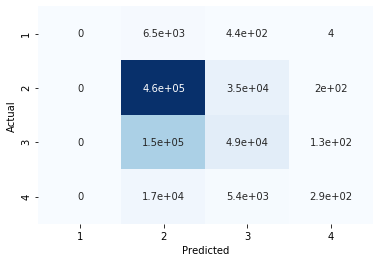

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix

p = []
t = []
for i in y_preds:
    p.append(np.argmax(i)+1)

for i in y_test:
    t.append(np.argmax(i)+1)    

print("accuracy:", accuracy_score(t, p))

cm=confusion_matrix(t,p)
cm = pd.DataFrame(cm, index = [i for i in "1234"],
                  columns = [i for i in "1234"])
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
sns.heatmap(cm, annot=True, 
            cmap='Blues', cbar=False)
plt.show()

In [13]:
from sklearn.model_selection import StratifiedKFold

data = feather.read_dataframe("{}_v2.feather".format(FILENAME))
labels = data['Severity']
X = data.drop('Severity', axis=1)

scaler=MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

skf = StratifiedKFold(n_splits=3, random_state=30034, shuffle=False)

fold_no = 1
accs = []  # store each accuracy


for train_index, test_index in skf.split(X, labels):

    # One hot encode labels
    print("FOLD NUMBER = ", str(fold_no))


    X_train = X[train_index]
    X_test = X[test_index]

    y_train = np.zeros((len(X_train), 4))
    for i in range(len(X_train)):
        y_train[i, labels[i]-1] = 1

    y_test = np.zeros((len(X_test), 4))
    for i in range(len(X_test)):
        y_test[i, labels[i]-1] = 1

    EPOCHS = 5
    BATCH_SIZE = 128

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(70, activation=tf.nn.swish,input_shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.Dense(4, activation=tf.nn.sigmoid))

    # Compile and print out summary of model
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                 metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
    (test_loss, test_acc) = model.evaluate(X_test, y_test)
    print('Accuracy:', test_acc)
    accs.append(test_acc)
    print("============================================")
    fold_no+=1

FOLD NUMBER =  1
Epoch 1/5
1948266/1948266 [==============================] - 14s 7us/sample - loss: 0.6620 - acc: 0.6621
Epoch 2/5
1948266/1948266 [==============================] - 14s 7us/sample - loss: 0.6598 - acc: 0.6623
Epoch 3/5
1948266/1948266 [==============================] - 14s 7us/sample - loss: 0.6596 - acc: 0.6623
Epoch 4/5
1948266/1948266 [==============================] - 14s 7us/sample - loss: 0.6595 - acc: 0.6623
Epoch 5/5
974134/974134 [==============================] - 11s 11us/sample - loss: 0.6592 - acc: 0.6746
Accuracy: 0.6745663
FOLD NUMBER =  2
Epoch 1/5
1948267/1948267 [==============================] - 15s 8us/sample - loss: 0.6369 - acc: 0.6635
Epoch 2/5
1948267/1948267 [==============================] - 16s 8us/sample - loss: 0.6327 - acc: 0.6642
Epoch 3/5
1948267/1948267 [==============================] - 17s 9us/sample - loss: 0.6321 - acc: 0.6645
Epoch 4/5
1948267/1948267 [==============================] - 16s 8us/sample - loss: 0.6317 - acc: 0.6646
Ep

In [24]:
grouped_sev = []
for i in data["Severity"].values:
    if i == 1 or i == 2:
        grouped_sev.append(0)
    else:
        grouped_sev.append(1)

data["Grouped_Severity"] = grouped_sev

In [ ]:
from sklearn.model_selection import StratifiedKFold

labels = data['Grouped_Severity']
X = data.drop(['Severity',"Grouped_Severity"], axis=1)

scaler=MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

skf = StratifiedKFold(n_splits=3, random_state=30034, shuffle=False)

fold_no = 1
accs = []  # store each accuracy


for train_index, test_index in skf.split(X, labels):

    # One hot encode labels
    print("FOLD NUMBER = ", str(fold_no))


    X_train = X[train_index]
    X_test = X[test_index]

    y_train = labels[train_index]
    y_test = labels[test_index]

    EPOCHS = 10
    BATCH_SIZE = 128

    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(40, input_dim=X_train.shape[1], activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
    (test_loss, test_acc) = model.evaluate(X_test, y_test)
    print('Accuracy:', test_acc)
    accs.append(test_acc)
    print("============================================")
    fold_no+=1

In [22]:
data = feather.read_dataframe("{}_numeric_v2.feather".format(FILENAME))

grouped_sev = []
for i in data["Severity"].values:
    if i == 1 or i == 2:
        grouped_sev.append(0)
    else:
        grouped_sev.append(1)

data["Grouped_Severity"] = grouped_sev

from sklearn.model_selection import StratifiedKFold

labels = data['Grouped_Severity']
X = data.drop(['Severity',"Grouped_Severity"], axis=1)

scaler=MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

skf = StratifiedKFold(n_splits=3, random_state=30034, shuffle=False)

fold_no = 1
accs = []  # store each accuracy


for train_index, test_index in skf.split(X, labels):

    # One hot encode labels
    print("FOLD NUMBER = ", str(fold_no))


    X_train = X[train_index]
    X_test = X[test_index]

    y_train = labels[train_index]
    y_test = labels[test_index]

    EPOCHS = 10
    BATCH_SIZE = 128

    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(40, input_dim=X_train.shape[1], activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
    (test_loss, test_acc) = model.evaluate(X_test, y_test)
    print('Accuracy:', test_acc)
    accs.append(test_acc)
    print("============================================")
    fold_no+=1

FOLD NUMBER =  1
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
1947713/1947713 [==============================] - 11s 6us/sample - loss: 0.5299 - acc: 0.7195
Epoch 2/10
1947713/1947713 [==============================] - 11s 6us/sample - loss: 0.5202 - acc: 0.7259
Epoch 3/10
1947713/1947713 [==============================] - 11s 6us/sample - loss: 0.5170 - acc: 0.7284
Epoch 4/10
1947713/1947713 [==============================] - 11s 6us/sample - loss: 0.5139 - acc: 0.7312
Epoch 5/10
1947713/1947713 [==============================] - 11s 6us/sample - loss: 0.5120 - acc: 0.7329
Epoch 6/10
1947713/1947713 [==============================] - 12s 6us/sample - loss: 0.5104 - acc: 0.7343
Epoch 7/10
1947713/1947713 [==============================] - 12s 6us/sample - loss: 0.5091 - acc: 0.7353
Epoch 8/10
1947713/1947713 [=

In [ ]:
cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
        'Wind_Speed(mph)', 'Precipitation(in)',
       'Population_County', 'Drive_County', 'Transit_County', 'Walk_County', 'MedianHouseholdIncome_County']

sns.set_style('darkgrid')
f, axes = plt.subplots(6,2, figsize=(15,20))
y = 0;
for name in cols[1:]:
    i, j = divmod(y, 2)
    sns.boxplot(x=data[name], ax=axes[i, j])
    y = y+1

plt.tight_layout()
plt.show()

### Performing one class SVM for outlier removal

In [9]:
def outlier_removal(data,columns):
    for col in columns:
        Q1 = np.quantile(data[col].values,0.25)
        Q3 = np.quantile(data[col].values,0.75)
        IQR = Q3-Q1
        
        lower = Q1 - 1.5*IQR
        upper = Q3+ 1.5*IQR
        
        data = data[(data[col]>=lower) & (data[col]<=upper)]
    return data


data = feather.read_dataframe("{}_numeric_v2.feather".format(FILENAME))

numeric_cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
        'Wind_Speed(mph)', 'Precipitation(in)',
       'Population_County', 'Drive_County', 'Transit_County', 'Walk_County', 'MedianHouseholdIncome_County']
new_data = outlier_removal(data,numeric_cols)
data

,Severity,Side,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Crossing,...,State_wisconsin,State_wyoming,Condition_Clear,Condition_Cloudy,Condition_Fog,Condition_Heavy Rain,Condition_Light Rain,Condition_Partly Cloudy,Condition_Rain,Condition_Snow
0,2,1.0,36.0,100.0,29.67,10.0,3.5,0.00,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,3,1.0,35.1,96.0,29.64,9.0,4.6,0.00,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,2,1.0,36.0,89.0,29.65,6.0,3.5,0.00,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,3,1.0,37.9,97.0,29.63,7.0,3.5,0.03,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
4,2,1.0,34.0,100.0,29.66,7.0,3.5,0.00,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2921565,2,1.0,86.0,40.0,28.92,10.0,13.0,0.00,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2921566,2,1.0,70.0,73.0,29.39,10.0,6.0,0.00,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2921567,2,1.0,73.0,64.0,29.74,10.0,10.0,0.00,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2921568,2,1.0,71.0,81.0,29.62,10.0,8.0,0.00,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0


In [10]:
new_data = new_data.reset_index(drop = True)

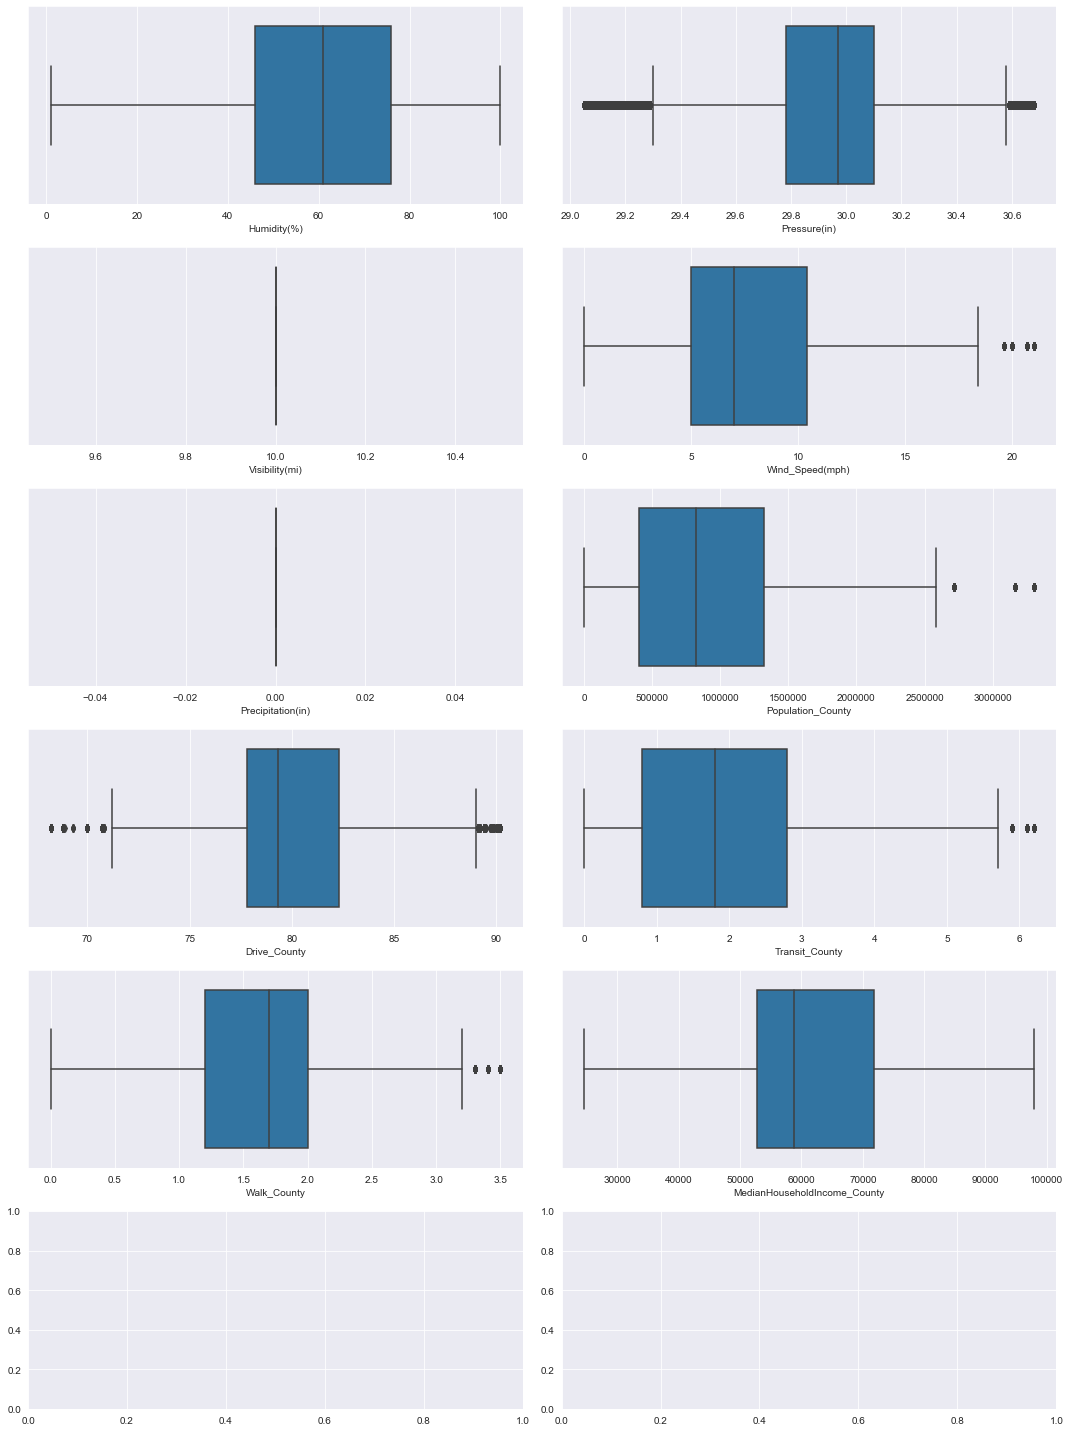

In [11]:
cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
        'Wind_Speed(mph)', 'Precipitation(in)',
       'Population_County', 'Drive_County', 'Transit_County', 'Walk_County', 'MedianHouseholdIncome_County']

sns.set_style('darkgrid')
f, axes = plt.subplots(6,2, figsize=(15,20))
y = 0;
for name in cols[1:]:
    i, j = divmod(y, 2)
    sns.boxplot(x=new_data[name], ax=axes[i, j])
    y = y+1

plt.tight_layout()
plt.show()

In [12]:
grouped_sev = []
for i in new_data["Severity"].values:
    if i == 1 or i == 2:
        grouped_sev.append(0)
    else:
        grouped_sev.append(1)

new_data["Grouped_Severity"] = grouped_sev

from sklearn.model_selection import StratifiedKFold

labels = new_data['Grouped_Severity']
X = new_data.drop(['Severity',"Grouped_Severity"], axis=1)

scaler=MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

skf = StratifiedKFold(n_splits=3, random_state=30034, shuffle=False)

fold_no = 1
accs = []  # store each accuracy


for train_index, test_index in skf.split(X, labels):

    # One hot encode labels
    print("FOLD NUMBER = ", str(fold_no))


    X_train = X[train_index]
    X_test = X[test_index]

    y_train = labels[train_index]
    y_test = labels[test_index]

    EPOCHS = 10
    BATCH_SIZE = 128

    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(40, input_dim=X_train.shape[1], activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
    (test_loss, test_acc) = model.evaluate(X_test, y_test)
    print('Accuracy:', test_acc)
    accs.append(test_acc)
    print("============================================")
    fold_no+=1

FOLD NUMBER =  1
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
850661/850661 [==============================] - 5s 6us/sample - loss: 0.5045 - acc: 0.7339
Epoch 2/10
850661/850661 [==============================] - 5s 6us/sample - loss: 0.4877 - acc: 0.7472
Epoch 3/10
850661/850661 [==============================] - 5s 6us/sample - loss: 0.4829 - acc: 0.7511
Epoch 4/10
850661/850661 [==============================] - 5s 6us/sample - loss: 0.4805 - acc: 0.7531
Epoch 5/10
850661/850661 [==============================] - 5s 6us/sample - loss: 0.4785 - acc: 0.7538
Epoch 6/10
850661/850661 [==============================] - 5s 6us/sample - loss: 0.4769 - acc: 0.7552
Epoch 7/10
850661/850661 [==============================] - 5s 6us/sample - loss: 0.4758 - acc: 0.7560
Epoch 8/10
850661/850661 [========================

KeyboardInterrupt: 